## Import required libraries and packages

In [1]:
import evaluate
import yaml
import nltk
nltk.download('punkt_tab', quiet=True)
import pathlib
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt 

In [ ]:
OUTPUT_PATH = "../benchmark_dir"
model_name = "gpt-4o"

## Helper functions

In [3]:
def create_path_generator(file_path):
    return pathlib.Path(f"{file_path}").glob("**/*")

In [4]:
def read_yaml_file(file_path, content_type):
    with open(file_path) as file:
        instructions = yaml.load(file, Loader=yaml.Loader)
    return yaml.dump(instructions[content_type])

In [5]:
path_generator = create_path_generator(
    file_path=f"{OUTPUT_PATH}/intermediate_responses/"
)
correct_response_file_paths = [str(path) for path in path_generator]
correct_response_file_paths = correct_response_file_paths[11:21]

In [6]:
bleu = evaluate.load("bleu")
google_bleu = evaluate.load("google_bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

Using the latest cached version of the module from C:\Users\Amilas_Windows_VM\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--bleu\9e0985c1200e367cce45605ce0ecb5ede079894e0f24f54613fca08eeb8aff76 (last modified on Thu Aug 29 09:22:20 2024) since it couldn't be found locally at evaluate-metric--bleu, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\Amilas_Windows_VM\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--google_bleu\6fc70b7be0088120a372dfdd5d320b39b8bb3630cb8029b193941d9376e86bb0 (last modified on Thu Aug 29 09:31:05 2024) since it couldn't be found locally at evaluate-metric--google_bleu, or remotely on the Hugging Face Hub.
Using the latest cached version of the module from C:\Users\Amilas_Windows_VM\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--rouge\b01e0accf3bd6dd24839b769a5fda24e14995071570870922c71970b3a6ed886 (last modified on Thu Aug 29 09:34:34 2024) since 

In [7]:
def remove_quotes_and_new_lines(instructions: str) -> list:
    instructions = instructions.replace("'", "").replace('"', "").split("- Step")
    instructions = [
        instruction.strip().replace("\n", "")
        for instruction in instructions
        if instruction != ""
    ]
    return instructions

In [ ]:
few_shot_metrics = []
for few_shot_count in tqdm(range(1, 7)):
    bleu_scores = []
    gleu_scores = []
    rouge_scores = []
    meteor_scores = []
    for test_index in tqdm(range(10)):
        correct_file_path = correct_response_file_paths[test_index]
        path_generator = create_path_generator(
            file_path=f"{OUTPUT_PATH}/few_shot_experiment/{model_name}/gpt_responses/{few_shot_count}_shot"
        )
        gpt_responses_file_paths = [str(path) for path in path_generator]
        predicted_file_path = gpt_responses_file_paths[test_index]

        # Correct instructions
        correct_instructions = read_yaml_file(
            file_path=correct_file_path, content_type="intermediate response"
        )
        correct_instructions = remove_quotes_and_new_lines(correct_instructions)

        # predicted instructions
        predicted_instructions = read_yaml_file(
            file_path=predicted_file_path, content_type="gpt_response"
        )
        predicted_instructions = remove_quotes_and_new_lines(predicted_instructions)
        predicted_instructions = ["\n".join(predicted_instructions)]
        correct_instructions = ["\n".join(correct_instructions)]

        if len(predicted_instructions) != len(correct_instructions):
            print(f"Predicted file: {predicted_file_path}")
            print(f"Correct file: {correct_file_path}")
            print(f"Predicted: {predicted_instructions}")
            print(f"Correct: {correct_instructions}")

        # BLEU
        bleu_results = bleu.compute(
            predictions=predicted_instructions, references=correct_instructions
        )
        bleu_scores.append(bleu_results["bleu"])

        # GLEU
        google_bleu_results = google_bleu.compute(
            predictions=predicted_instructions, references=correct_instructions
        )
        gleu_scores.append(google_bleu_results["google_bleu"])

        # Rouge-L
        rouge_results = rouge.compute(
            predictions=predicted_instructions, references=correct_instructions
        )
        rouge_scores.append(rouge_results["rougeL"])

        # METEOR
        meteor_results = meteor.compute(
            predictions=predicted_instructions, references=correct_instructions
        )
        meteor_scores.append(meteor_results["meteor"])

    Z_90_CONFIDENCE_INTERVAL = 1.645
    metrics = {
        "mean_bleu": np.mean(bleu_scores),
        "std_bleu": np.std(bleu_scores),
        "ci_bleu": (Z_90_CONFIDENCE_INTERVAL * np.std(bleu_scores)) / np.sqrt(10),
        "mean_gleu": np.mean(gleu_scores),
        "std_gleu": np.std(gleu_scores),
        "ci_gleu": (Z_90_CONFIDENCE_INTERVAL * np.std(gleu_scores)) / np.sqrt(10),
        "mean_rouge": np.mean(rouge_scores),
        "std_rouge": np.std(rouge_scores),
        "ci_rouge": (Z_90_CONFIDENCE_INTERVAL * np.std(rouge_scores)) / np.sqrt(10),
        "mean_meteor": np.mean(meteor_scores),
        "std_meteor": np.std(meteor_scores),
        "ci_meteor": (Z_90_CONFIDENCE_INTERVAL * np.std(meteor_scores)) / np.sqrt(10),
    }
    few_shot_metrics.append(metrics)

100%|██████████| 10/10 [00:37<00:00,  3.72s/it]


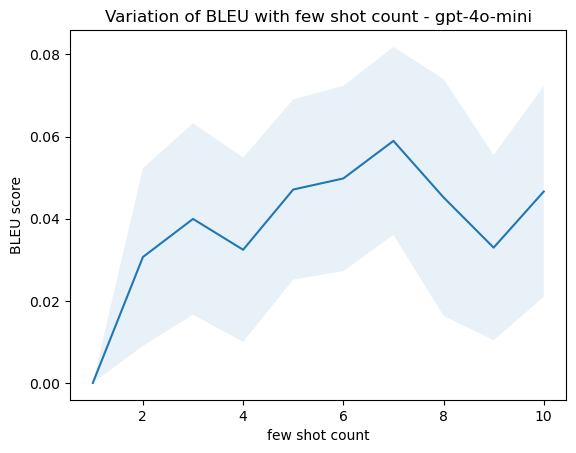

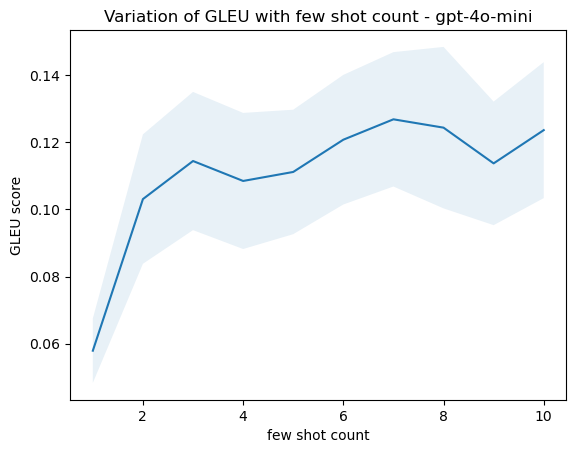

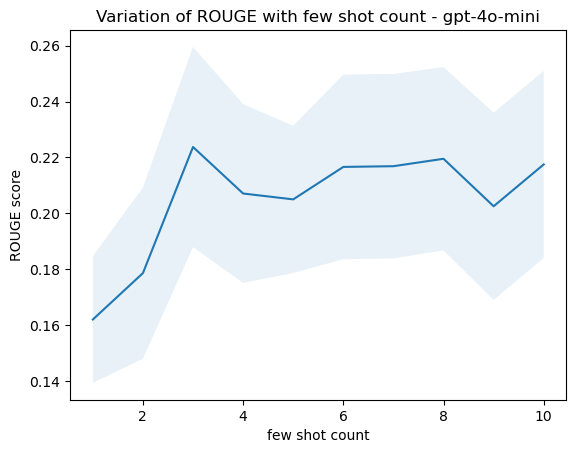

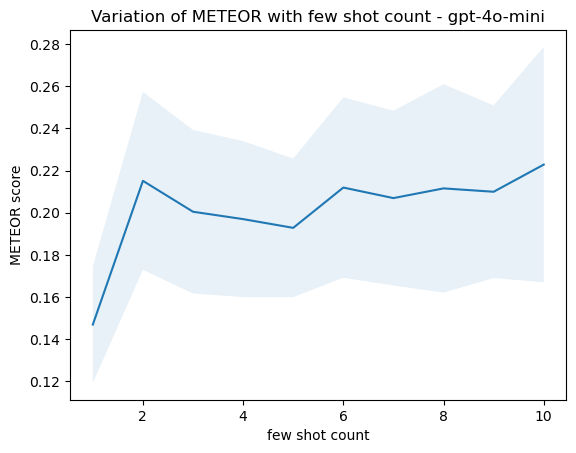

In [9]:
for metric in ["bleu", "gleu", "rouge", "meteor"]:
    x = np.array(range(1, 11))
    y = np.array([item[f"mean_{metric}"] for item in few_shot_metrics])
    ci = np.array([item[f"ci_{metric}"] for item in few_shot_metrics])
    plt.plot(x, y)
    plt.fill_between(x, (y-ci), (y+ci), alpha=0.1)
    plt.ylabel(f"{metric.upper()} score")
    plt.xlabel("few shot count")
    plt.title(f"Variation of {metric.upper()} with few shot count - {model_name}")
    plt.show()